In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division
import os, sys
import numpy as np, scipy as sp, pandas as pd
import scipy.io
import scipy.signal as signal, scipy.fftpack as ftpk, scipy.integrate as integrate, scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import sampen

original_dir = os.getcwd()

In [3]:
PLOT=True

In [4]:
e = np.exp(1)
pi = np.pi
pii = np.pi*1j
twopi = np.pi * 2
SR=400

In [5]:
import pywt
# import pyhht

In [6]:
from imp import reload
import auxfilter
import glob

In [7]:
os.chdir(original_dir + '/..')
# os.chdir('/home/mike/venvs/ml/ml/py')
print(os.getcwd())
from eegkaggle.vectorizers import naive, spectral
from eegkaggle.dio import dataio
from eegkaggle.plotting import plotstuff
from eegkaggle.msignal import wavelets, metrics

/home/mike/venvs/ml/ml/py


In [8]:
reload(plotstuff)
reload(dataio)

<module 'eegkaggle.dio.dataio' from 'eegkaggle/dio/dataio.pyc'>

In [9]:
matplotlib.style.use('ggplot')

In [10]:
ssmall,smed, slarge, slong = (4,3), (8,6), (16,12), (16,4)
matplotlib.rcParams['figure.figsize'] = smed

Functions

Data loading section

In [11]:
dat = dataio.get_matlab_eeg_data_ary('/home/mike/Downloads/train_1/1_100_0.mat')

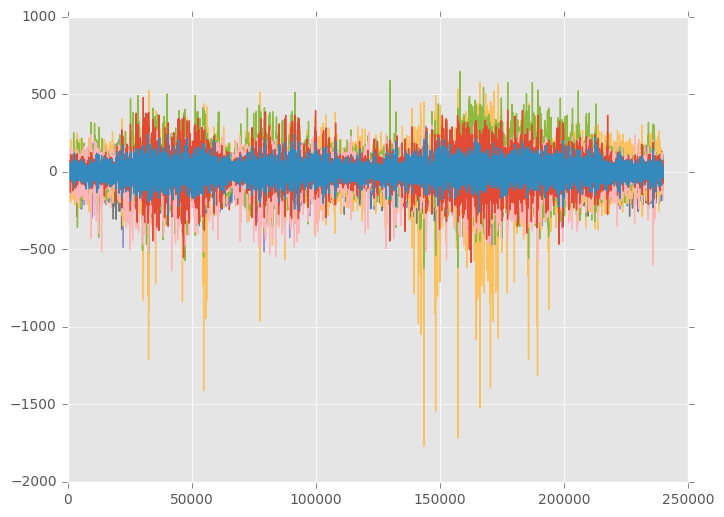

In [12]:
plt.plot(dat)

In [17]:
# dnorm = sampen.sampen2(dat[:,0]) SLOW AF!!!

In [23]:
spool = []
for i in range(len(dat)):
    spool.append('{}'.format(dat[i,0]))
stream = '\n'.join(spool)

In [24]:
from subprocess import Popen, PIPE
from sys import argv

#     input = ' '.join(argv[1:])
if not input: input = "no arguments given"
cproc = Popen("/home/mike/src/SampEn/sampen", stdin=PIPE, stdout=PIPE)
out, err = cproc.communicate(stream)
print("output:", out)
print("errors:", err)

output: SampEn(0,0.2,240000) = 1.439925
SampEn(1,0.2,240000) = 3.416581
SampEn(2,0.2,240000) = 3.002683

errors: None
